**NETWORK ANALYSIS OF TRUST-BASED TRANSACTIONS IN THE BITCOIN OTC NETWORK**

In [35]:
# Load the libraires
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Dataset Acquisition**

In [8]:
# Load the dataset
data = pd.read_csv("soc-sign-bitcoinotc.csv.gz", compression='gzip', names=["source", "target", "rating", "timestamp"])

display(data.shape)
data.sample(10)

(35592, 4)

,source,target,rating,timestamp
3198,782,784,1,1.306966e+09
22101,4163,4181,1,1.367124e+09
7567,353,1562,1,1.323376e+09
7433,1605,1566,2,1.322317e+09
17585,3202,1810,1,1.357695e+09
15785,2877,827,-1,1.352938e+09
29512,546,4038,-5,1.385849e+09
22323,4206,4198,2,1.367470e+09
23047,3445,1185,2,1.369196e+09
10266,2085,2088,1,1.337654e+09


**Data Preprocessing**

    1. Format the dataset for network analysis - check for duplicates, convert the timestamp
    2. Convert the dataset into a graph representation using NetworkX.

In [9]:
# Step 1: Handle Missing Values
data.dropna(inplace=True)  # Drop rows with any missing values

# Step 2: Remove Duplicate Edges (Keep highest trust rating per transaction)
data.sort_values(by=["source", "target", "rating"], ascending=[True, True, False], inplace=True)
data.drop_duplicates(subset=["source", "target"], keep="first", inplace=True)

# Step 3: Convert UNIX Timestamp to Datetime
data["timestamp"] = pd.to_datetime(data["timestamp"], unit='s')

# Step 4: Check and Remove Self-loops (Users rating themselves)
data = data[data["source"] != data["target"]]
display(data.sample(5))

# Create Directed Graph Using 
G = nx.from_pandas_edgelist(data, source="source", target="target", edge_attr=["rating", "timestamp"], create_using=nx.DiGraph())

# Step 7: Print Summary
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Date Range: {data['timestamp'].min()} to {data['timestamp'].max()}")

,source,target,rating,timestamp
30037,3099,4833,3,2013-12-18 07:01:41.188260078
24537,4532,1018,3,2013-07-08 20:21:46.115129948
35065,5227,5945,1,2015-05-13 13:54:21.714519978
11443,2256,2127,1,2012-07-05 08:08:25.628230095
361,2,110,1,2011-02-16 17:45:31.025209904


Number of nodes: 5881
Number of edges: 35592
Date Range: 2010-11-08 18:45:11.728359938 to 2016-01-25 01:12:03.757280111


In [80]:
G

**Deep Research Questions Based on the Dataset**

**Research Question 1:**
    **What is the distribution of trust scores in the Bitcoin OTC network?**

In [123]:
# Sort the dictionary by keys in ascending order
sorted_dict = dict(sorted(data["rating"].value_counts().items()))

# Display the keys and values in horizontal form
for key, value in sorted_dict.items():
    print(f"{key}: {value}", end="  ")

-10: 2413  -9: 20  -8: 31  -7: 14  -6: 5  -5: 179  -4: 27  -3: 91  -2: 182  -1: 601  1: 20048  2: 5562  3: 2561  4: 967  5: 1268  6: 265  7: 208  8: 277  9: 108  10: 765  

    Rating which also mean trust scores indicate *how much confidence* user have in each 
    other during transactions, Therefore, understanding the distribution of trust reveals 
    *if there are high-trust or low-trust or it is evenly spread* 

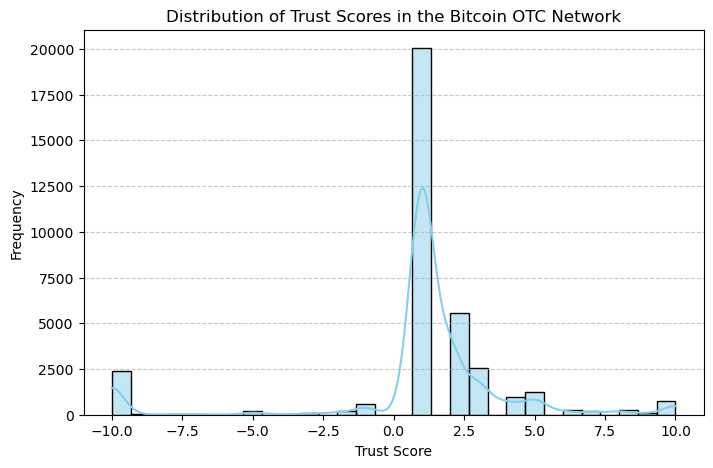

In [10]:
# Extract trust scores
trust_scores = data["rating"]

# Plot the distribution
plt.figure(figsize=(8, 5))

# Use Seaborn to plot a histogram with a KDE line
sns.histplot(trust_scores, bins=30, kde=True, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Trust Score")
plt.ylabel("Frequency")
plt.title("Distribution of Trust Scores in the Bitcoin OTC Network")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

*from the visuals, rating 1 appears the most, implying low mean trust, users are catious on who to trust.*

In [35]:
# Compute basic statistics
mean_trust = trust_scores.mean()
median_trust = trust_scores.median()
variance_trust = trust_scores.var()

# Count negative trust scores
negative_trust_count = (trust_scores < 0).sum()

# Print results
print(f"Mean Trust Score: {mean_trust:.2f}")
print(f"Median Trust Score: {median_trust:.2f}")
print(f"Variance of Trust Scores: {variance_trust:.2f}")
print(f"Number of Negative Trust Scores: {negative_trust_count}")

Mean Trust Score: 1.01
Median Trust Score: 1.00
Variance of Trust Scores: 12.69
Number of Negative Trust Scores: 3563


*The distribution shows a network with a heavy concentration of neutral to slightly positive trust ratings.
However, the variability and presence of a substantial number of negative ratings demonstrate that 
the network has a mix of cooperative and adversarial relationships, likely reflective of differing levels
of user confidence and interaction quality.*

**Research Question 2: How do high-trust and low-trust transactions differ in terms of network structure?**

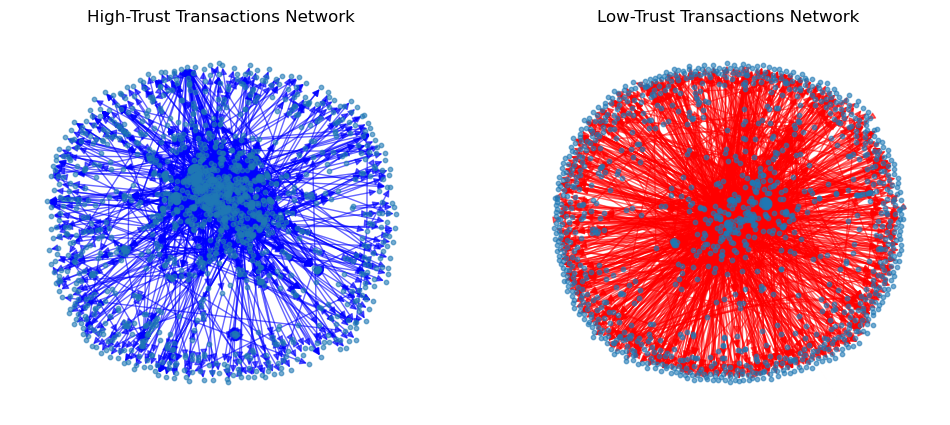

In [12]:
# Define trust thresholds
high_trust_threshold = 5
low_trust_threshold = -5

# Filter high-trust and low-trust transactions
high_trust_data = data[data["rating"] >= high_trust_threshold]
low_trust_data = data[data["rating"] <= low_trust_threshold]

# Create separate graphs
G_high_trust = nx.from_pandas_edgelist(high_trust_data, source="source", target="target", 
                                       create_using=nx.DiGraph())
G_low_trust = nx.from_pandas_edgelist(low_trust_data, source="source", target="target", 
                                        create_using=nx.DiGraph())

# Plot High-Trust Network
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
nx.draw(G_high_trust, node_size=10, edge_color="blue", alpha=0.6, with_labels=False)
plt.title("High-Trust Transactions Network")

# Plot Low-Trust Network
plt.subplot(1, 2, 2)
nx.draw(G_low_trust, node_size=10, edge_color="red", alpha=0.6, with_labels=False)
plt.title("Low-Trust Transactions Network")

plt.show()

✅ High-trust users tend to operate in well-connected, stable communities with repeat transactions.

✅ Low-trust transactions involve more scattered, unstructured interactions, possibly indicating 
uncertainty or one-time deals.

In [25]:
# Convert directed graphs to undirected graphs
G_high_trust_undirected = G_high_trust.to_undirected()
G_low_trust_undirected = G_low_trust.to_undirected()


In [43]:
import community.community_louvain as community_louvain

# Detect communities in the high-trust network (now undirected)
high_trust_partition = community_louvain.best_partition(G_high_trust_undirected)

# Detect communities in the low-trust network (now undirected)
low_trust_partition = community_louvain.best_partition(G_low_trust_undirected)

# Print the number of communities
print(f"Number of communities in High-Trust Network: {len(set(high_trust_partition.values()))}")
print(f"Number of communities in Low-Trust Network: {len(set(low_trust_partition.values()))}")

# Visualize the communities in the High-Trust Network
#plt.figure(figsize=(8, 6))
#nx.draw(
   # G_high_trust_undirected,
    #node_color=[low_trust_partition[node] for node in G_low_trust_undirected.nodes()],
    #node_size=30,
    #cmap=plt.cm.jet,
    #with_labels=False
#)
#plt.title("Communities in High-Trust Network")
#plt.show()


Number of communities in High-Trust Network: 152
Number of communities in Low-Trust Network: 86


In [43]:
# Compute average degree
avg_degree_high = sum(dict(G_high_trust.degree()).values()) / len(G_high_trust.nodes())
avg_degree_low = sum(dict(G_low_trust.degree()).values()) / len(G_low_trust.nodes())

# Compute clustering coefficient
clustering_high = nx.average_clustering(G_high_trust)
clustering_low = nx.average_clustering(G_low_trust)

# Compute number of connected components
connected_components_high = nx.number_weakly_connected_components(G_high_trust)
connected_components_low = nx.number_weakly_connected_components(G_low_trust)

# Print results
print(f"High-Trust Transactions Network:")
print(f"  - Average Degree: {avg_degree_high:.2f}")
print(f"  - Average Clustering Coefficient: {clustering_high:.2f}")
print(f"  - Number of Connected Components: {connected_components_high}")

print(f"\nLow-Trust Transactions Network:")
print(f"  - Average Degree: {avg_degree_low:.2f}")
print(f"  - Average Clustering Coefficient: {clustering_low:.2f}")
print(f"  - Number of Connected Components: {connected_components_low}")

High-Trust Transactions Network:
  - Average Degree: 3.64
  - Average Clustering Coefficient: 0.06
  - Number of Connected Components: 132

Low-Trust Transactions Network:
  - Average Degree: 4.29
  - Average Clustering Coefficient: 0.01
  - Number of Connected Components: 72


✅ High-trust transactions form tight-knit, well-clustered communities where users interact within trusted circles.
    
✅ Low-trust transactions show wider connectivity but weaker relationships, suggesting riskier, less structured transactions.

✅ The higher number of components in the high-trust network suggests that trust leads to fragmentation, 
whereas low-trust transactions remain more widespread and connected.

**Research Question 3: What role do central users play in transaction reconciliation, and how does their influence change over time?**

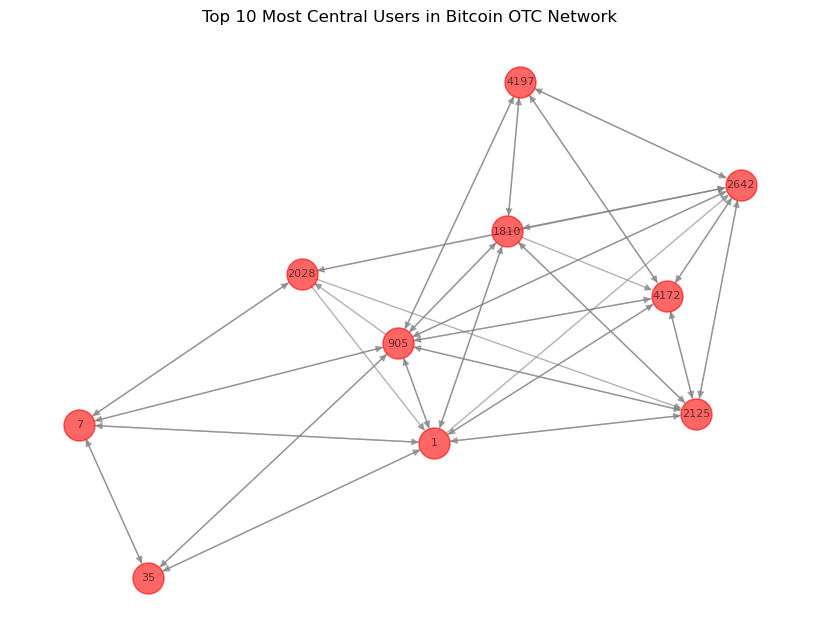

In [29]:
# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G)

# Get top 10 most central users
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]

# Extract node IDs for visualization
top_users = [user[0] for user in top_degree]

# Subgraph of central users
subgraph = G.subgraph(top_users)

# Visualize top central users
plt.figure(figsize=(8, 4))
nx.draw(subgraph, node_size=500, node_color="red", with_labels=True, font_size=8, edge_color="gray", alpha=0.6)
plt.title("Top 10 Most Central Users in Bitcoin OTC Network")
plt.show()

    Degree Centrality – Measures how many direct connections a node has.
    Betweenness Centrality – Identifies nodes that act as bridges between different parts of the network.
    Closeness Centrality – Determines how quickly a node can reach all others.
    PageRank – Ranks nodes based on their importance in spreading information.

In [31]:
# Define time periods (e.g., group by month)
data["year_month"] = data["timestamp"].dt.to_period("M")

# Compute degree centrality for each time period
time_centrality = {}

for period in data["year_month"].unique():
    sub_data = data[data["year_month"] == period]
    G_sub = nx.from_pandas_edgelist(sub_data, source="source", target="target", create_using=nx.DiGraph())
    degree_centrality_sub = nx.degree_centrality(G_sub)
    time_centrality[period] = degree_centrality_sub

# Convert to DataFrame for analysis
centrality_df = pd.DataFrame(time_centrality).T.fillna(0)

# Display top users' influence over time
#centrality_df.head(10)  # Shows centrality values for top users across time


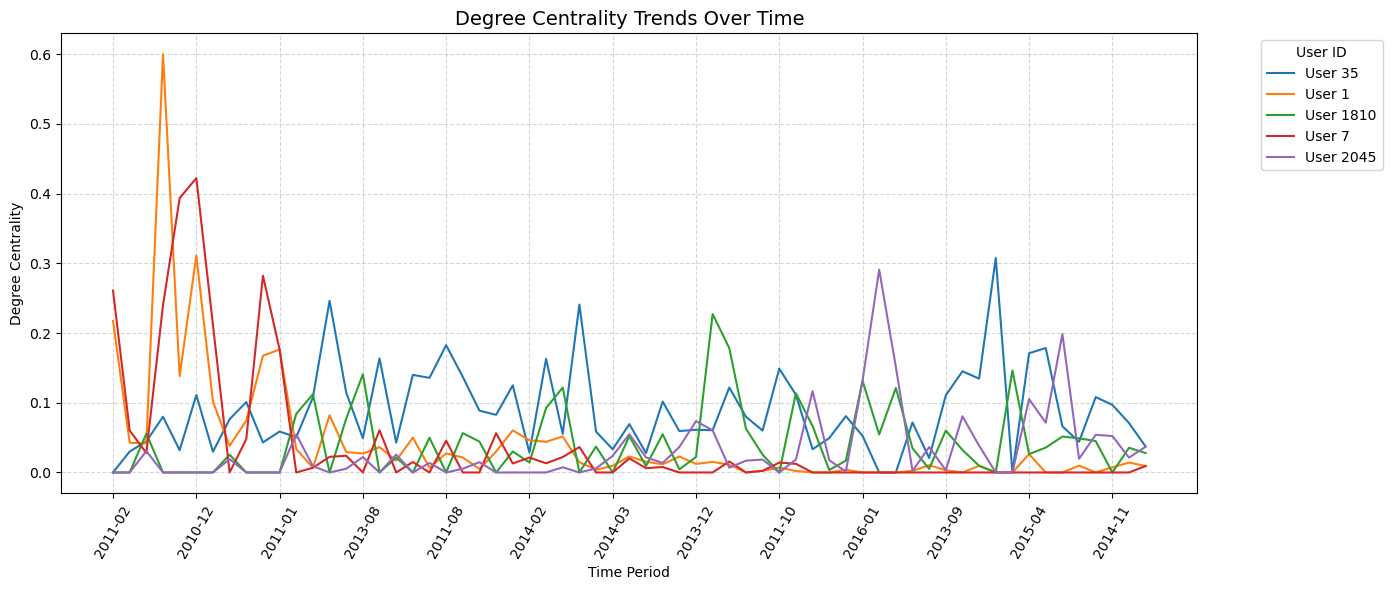

In [37]:
# Plot the line graph
plt.figure(figsize=(14, 6))

# Select top N users with the highest average centrality over time
top_users = centrality_df.mean().sort_values(ascending=False).head(5).index

for user in top_users:
    plt.plot(centrality_df.index.astype(str), centrality_df[user], label=f"User {user}")

# Formatting
plt.title("Degree Centrality Trends Over Time", fontsize=14)
plt.xlabel("Time Period")
plt.ylabel("Degree Centrality")

# Optimize xticks (reduce clutter)
xtick_positions = np.arange(0, len(centrality_df.index), step=5)  # Show every 5th tick
plt.xticks(xtick_positions, centrality_df.index[xtick_positions].astype(str), rotation=60)

plt.legend(title="User ID", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()  # Adjust layout to fit x-labels
plt.show()


The graph illustrates degree centrality trends over time for selected users in the Bitcoin OTC network. 
Degree centrality measures how connected a user is within the network, reflecting their role in transaction reconciliation.

    == Some users (e.g., User 1 and User 7) exhibited early spikes in centrality, suggesting that they were highly active in facilitating transactions during specific periods but later declined in influence.
    == Other users (e.g., User 35 and User 2045) maintained sporadic or moderate centrality, indicating sustained but fluctuating participation in the network.
    == The overall declining trend in centrality suggests that no single user retained dominance over time, possibly due to shifts in trust or the entry of new participants in the network.

**Research Question 4: How does transaction volume and trust score evolve over time?**

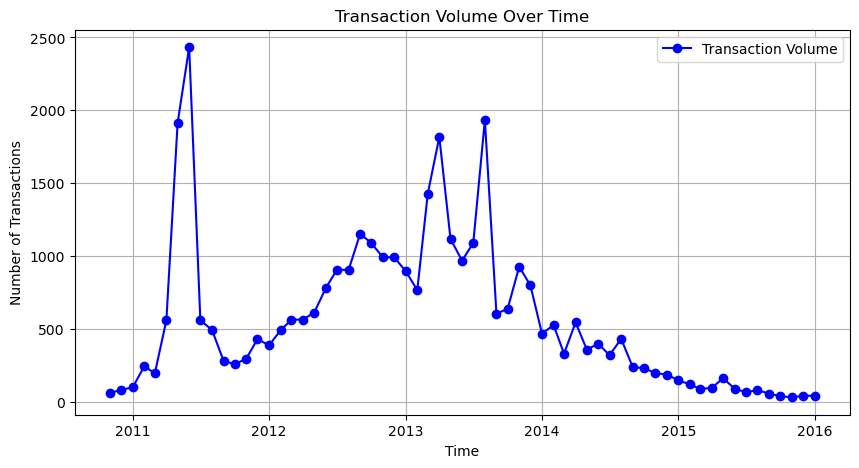

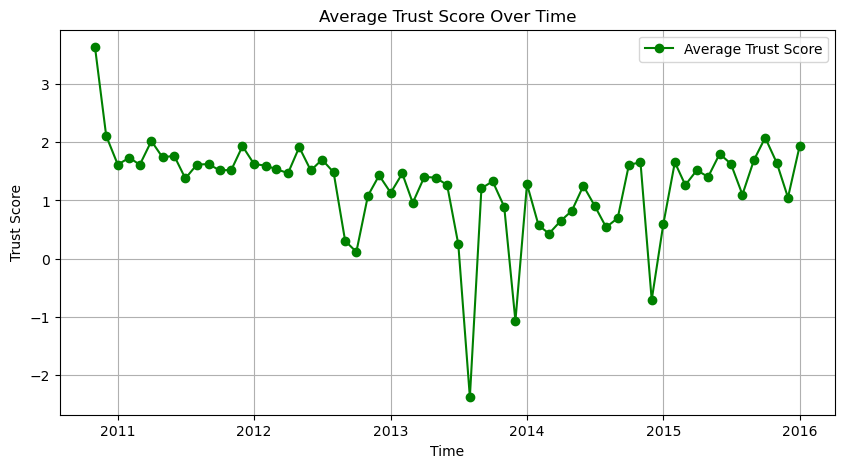

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure timestamps are in datetime format
data["timestamp"] = pd.to_datetime(data["timestamp"], unit="s")

# Group by month and compute transaction volume & average trust score
data["year_month"] = data["timestamp"].dt.to_period("M")
transaction_trends = data.groupby("year_month").agg({"rating": ["count", "mean"]})
transaction_trends.columns = ["Transaction Volume", "Average Trust Score"]

# Convert period index to datetime for plotting
transaction_trends.index = transaction_trends.index.to_timestamp()

# Plot transaction volume over time
plt.figure(figsize=(10, 5))
plt.plot(transaction_trends.index, transaction_trends["Transaction Volume"], marker='o', linestyle='-', color="blue", label="Transaction Volume")
plt.xlabel("Time")
plt.ylabel("Number of Transactions")
plt.title("Transaction Volume Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot average trust score over time
plt.figure(figsize=(10, 5))
plt.plot(transaction_trends.index, transaction_trends["Average Trust Score"], marker='o', linestyle='-', color="green", label="Average Trust Score")
plt.xlabel("Time")
plt.ylabel("Trust Score")
plt.title("Average Trust Score Over Time")
plt.grid(True)
plt.legend()
plt.show()

    Transaction Volume Over Time (Top Graph)

        The number of transactions fluctuates significantly over time, with notable peaks around 2011-2013.
        There is a sharp increase in transaction volume in 2011, reaching a peak close to 2500 transactions.
        After 2013, the volume shows a general declining trend, with periodic spikes. By 2015-2016, the transaction activity diminishes significantly.

    Average Trust Score Over Time (Bottom Graph)

    The trust score starts high (~3.5) but declines over time, showing volatility.
    There are multiple drops in trust scores, particularly in 2013 and 2014, where negative values are observed.
    Trust scores recover slightly after 2014 but remain unstable.

In [53]:
# Compute percentage change in transaction volume & trust score
transaction_trends["Transaction Volume Change (%)"] = transaction_trends["Transaction Volume"].pct_change() * 100
transaction_trends["Trust Score Change (%)"] = transaction_trends["Average Trust Score"].pct_change() * 100

# Display key statistics
transaction_trends.head(10)  # Show first 10 time periods

,Transaction Volume,Average Trust Score,Transaction Volume Change (%),Trust Score Change (%)
year_month,,,,
2010-11-01,60,3.633333,NaN,NaN
2010-12-01,82,2.109756,36.666667,-41.933318
2011-01-01,99,1.616162,20.731707,-23.395808
2011-02-01,245,1.734694,147.474747,7.334184
2011-03-01,194,1.613402,-20.816327,-6.992116
2011-04-01,559,2.021467,188.144330,25.292198
2011-05-01,1911,1.739403,241.860465,-13.953404
2011-06-01,2433,1.768598,27.315542,1.678448
2011-07-01,558,1.378136,-77.065351,-22.077495


**Research Question 5: Do some users frequently engage in inconsistent or fluctuating trust ratings?**

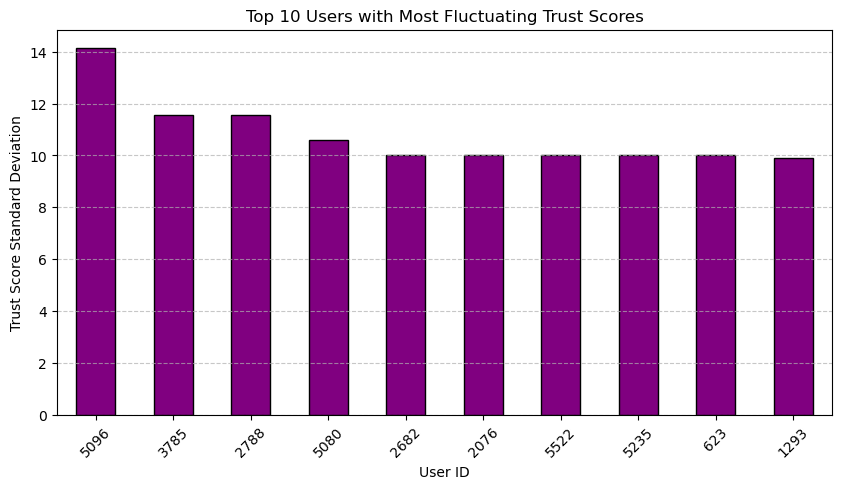

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute trust score standard deviation per user
user_trust_variability = data.groupby("source")["rating"].std().dropna()

# Identify top 10 users with the highest trust variability
top_fluctuating_users = user_trust_variability.sort_values(ascending=False).head(10)

# Plot variability in trust ratings for top fluctuating users
plt.figure(figsize=(10, 5))
top_fluctuating_users.plot(kind="bar", color="purple", edgecolor="black")
plt.xlabel("User ID")
plt.ylabel("Trust Score Standard Deviation")
plt.title("Top 10 Users with Most Fluctuating Trust Scores")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [57]:
# Compute trust variability statistics
mean_variability = user_trust_variability.mean()
high_variability_users = (user_trust_variability > mean_variability * 2).sum()  # Users with 2x the average fluctuation

# Print results
print(f"Average Trust Score Variability: {mean_variability:.2f}")
print(f"Number of High Variability Users: {high_variability_users}")

Average Trust Score Variability: 1.75
Number of High Variability Users: 546


**Research Question 6: Are transactions with lower trust scores more likely to involve users with fewer connections?**

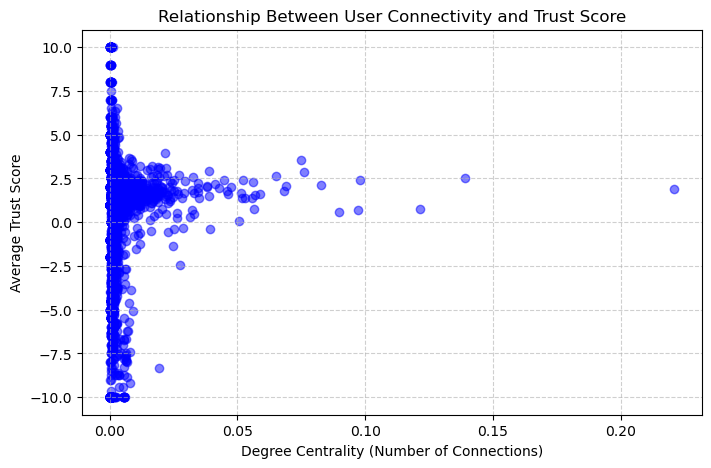

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

# Compute degree centrality (number of connections per user)
degree_centrality = nx.degree_centrality(G)

# Compute average received trust score per user
user_avg_trust = data.groupby("target")["rating"].mean()

# Merge centrality and trust score data
user_analysis = pd.DataFrame({"degree_centrality": degree_centrality, "avg_trust_score": user_avg_trust}).dropna()

# Scatter plot: User Connections vs. Trust Score
plt.figure(figsize=(8, 5))
plt.scatter(user_analysis["degree_centrality"], user_analysis["avg_trust_score"], alpha=0.5, color="blue")
plt.xlabel("Degree Centrality (Number of Connections)")
plt.ylabel("Average Trust Score")
plt.title("Relationship Between User Connectivity and Trust Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [61]:
# Compute correlation between degree centrality and trust score
correlation = user_analysis["degree_centrality"].corr(user_analysis["avg_trust_score"])

# Print results
print(f"Correlation between Degree Centrality and Trust Score: {correlation:.2f}")

Correlation between Degree Centrality and Trust Score: 0.04


    Given the broad scatter of points, degree centrality alone is not a strong predictor of a user’s trust score. 
    Other factors—such as transaction history, reputation, or external events—likely play a significant role in determining 
    how trusted or distrusted a user becomes.

    In summary, while higher connectivity might offer some advantages in establishing trust, the plot shows that trust 
    levels vary greatly even for users with similar connectivity, leading to a weak or negligible overall correlation.